In [1]:
#!pip install -U pandas
#!pip install -U scikit-learn
#!pip install -U matplotlib
#!pip install tensorflow
#!pip install -U transformers
#!pip install -U tf-keras
#!pip install -U focal-loss
#!pip install -U nltk

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, TFDistilBertModel
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
import re,string,unicodedata
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

/home/john/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 15:29:45.373182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733171385.389779   17612 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733171385.394739   17612 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 15:29:45.412278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations

In [3]:
df = pd.read_csv('data/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


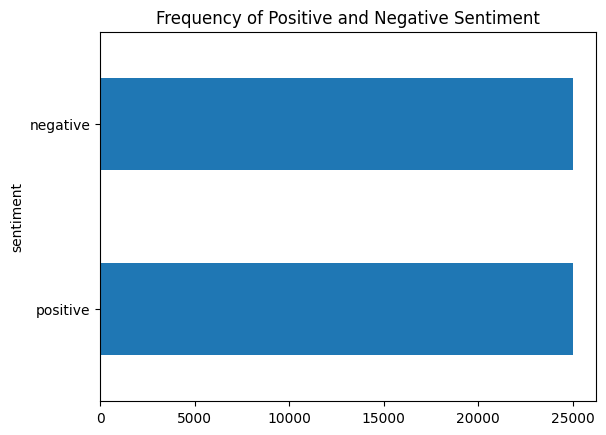

In [4]:
df["sentiment"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Positive and Negative Sentiment")
plt.show()

# Data Cleaning

### Deleting duplicate rows

In [5]:
df.drop_duplicates(inplace = True)

### Removing abbreviations and html

In [6]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

stop = stopwords.words('english')
wl = WordNetLemmatizer()

#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

# DistilBERT

In [7]:
# Convert sentiment to numerical value
df['sentiment'] = (df['sentiment'] == 'positive').astype(int)

# Preprocess text
df['review'] = df['review'].apply(clean_text, lemmatize=False)

# Split into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

/tmp/ipykernel_17612/3663773812.py:43: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #remove html tags


In [8]:
# Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [9]:
print("Total samples:", len(df))
print("Training samples:", len(train))
print("Validation samples:", len(val))
print("Test samples:", len(test))

Total samples: 49582
Training samples: 31732
Validation samples: 7933
Test samples: 9917


In [10]:
# Was running out of gpu memory (only have 3Gb) so this is hard-coded 
max_seq_len = 128

In [11]:
def tokenize_texts(texts, max_length=128):
    text_list = texts.tolist()
    
    encodings = tokenizer(
        text_list, 
        max_length=max_length, 
        truncation=True, 
        padding='max_length', 
        return_tensors='tf'
    )
    
    return encodings['input_ids'], encodings['attention_mask']

# Tokenize data
Xtrain_ids, Xtrain_mask = tokenize_texts(train['review'], max_seq_len)
ytrain_array = train['sentiment'].values

Xval_ids, Xval_mask = tokenize_texts(val['review'], max_seq_len)
yval_array = val['sentiment'].values

Xtest_ids, Xtest_mask = tokenize_texts(test['review'], max_seq_len)
ytest_array = test['sentiment'].values

I0000 00:00:1733171420.045907   17612 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2069 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [12]:
def create_tf_dataset(input_ids, attention_mask, labels, batch_size=32):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': tf.convert_to_tensor(input_ids, dtype=tf.int32), 
            'attention_mask': tf.convert_to_tensor(attention_mask, dtype=tf.int32)
        },
        labels
    )).batch(batch_size)

# Create datasets
train_dataset = create_tf_dataset(Xtrain_ids, Xtrain_mask, ytrain_array)
val_dataset = create_tf_dataset(Xval_ids, Xval_mask, yval_array)
test_dataset = create_tf_dataset(Xtest_ids, Xtest_mask, ytest_array)

In [13]:
def create_bert_model(transformer, max_len):
    input_ids_layer = Input(shape=(max_len,), dtype='int32', name='input_ids')
    attention_mask_layer = Input(shape=(max_len,), dtype='int32', name='attention_mask')
    
    transformer.trainable = False

    def transformer_model(inputs):
        input_ids, attention_mask = inputs
        return transformer(input_ids=input_ids, attention_mask=attention_mask)[0]
    
    # I have no idea what's going on here. When I switched from my
    # laptop to my computer, I started getting a type error.
    # I couldnt find anything online about the type error I was getting,
    # so I asked claude and got this ...
    bert_outputs = tf.keras.layers.Lambda(
        transformer_model, 
        output_shape=(max_len, transformer.config.hidden_size)
    )([input_ids_layer, attention_mask_layer])
    
    
    x = GlobalAveragePooling1D()(bert_outputs)
    x = Dropout(0.1)(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(
        inputs={'input_ids': input_ids_layer, 'attention_mask': attention_mask_layer}, 
        outputs=output
    )
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

In [14]:
# Load pre-trained DistilBERT model
transformer = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [15]:
model = create_bert_model(transformer, max_seq_len)

I0000 00:00:1733171424.301936   17695 service.cc:148] XLA service 0x75b6a0003f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733171424.301962   17695 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
W0000 00:00:1733171424.337948   17695 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
2024-12-02 15:30:24.361943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733171424.482655   17695 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/310 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step

I0000 00:00:1733171425.796497   17695 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

W0000 00:00:1733171464.016318   17695 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


310/310 ━━━━━━━━━━━━━━━━━━━━ 42s 129ms/step
Random Forest Classifier Accuracy : 46.87%


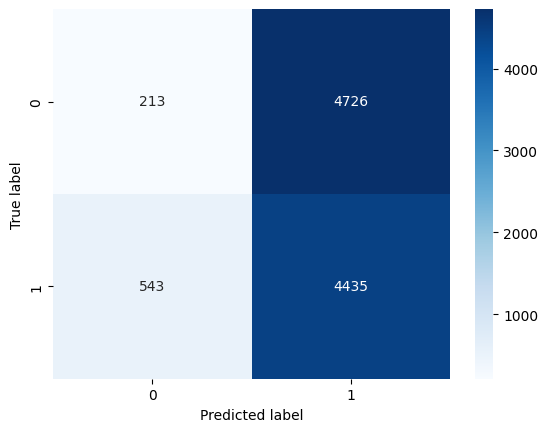

In [16]:
ypred = model.predict(test_dataset)
ypred = ypred>0.5

s2=accuracy_score(ytest_array,ypred)
print("Random Forest Classifier Accuracy :", "{:.2f}%".format(100*s2))

#Get the confusion matrix
cf_matrix = confusion_matrix(ytest_array, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [17]:
base_bert_report = classification_report(ytest_array, ypred)
print(base_bert_report)

              precision    recall  f1-score   support

           0       0.28      0.04      0.07      4939
           1       0.48      0.89      0.63      4978

    accuracy                           0.47      9917
   macro avg       0.38      0.47      0.35      9917
weighted avg       0.38      0.47      0.35      9917



# Fine-tuning DistilBERT

In [18]:
epochs = 6
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs
)

Epoch 1/6


W0000 00:00:1733171470.121807   17696 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


991/992 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7078 - loss: 0.5824

W0000 00:00:1733171598.581631   17693 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


992/992 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7078 - loss: 0.5823

W0000 00:00:1733171601.790384   17693 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
W0000 00:00:1733171633.412822   17695 assert_op.cc:38] Ignoring Assert operator functional_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


992/992 ━━━━━━━━━━━━━━━━━━━━ 168s 164ms/step - accuracy: 0.7079 - loss: 0.5823 - val_accuracy: 0.7863 - val_loss: 0.4657
Epoch 2/6
992/992 ━━━━━━━━━━━━━━━━━━━━ 160s 162ms/step - accuracy: 0.7944 - loss: 0.4542 - val_accuracy: 0.7968 - val_loss: 0.4397
Epoch 3/6
992/992 ━━━━━━━━━━━━━━━━━━━━ 161s 162ms/step - accuracy: 0.8046 - loss: 0.4338 - val_accuracy: 0.8039 - val_loss: 0.4273
Epoch 4/6
992/992 ━━━━━━━━━━━━━━━━━━━━ 161s 163ms/step - accuracy: 0.8049 - loss: 0.4247 - val_accuracy: 0.8081 - val_loss: 0.4205
Epoch 5/6
992/992 ━━━━━━━━━━━━━━━━━━━━ 162s 163ms/step - accuracy: 0.8084 - loss: 0.4197 - val_accuracy: 0.8068 - val_loss: 0.4178
Epoch 6/6
992/992 ━━━━━━━━━━━━━━━━━━━━ 158s 159ms/step - accuracy: 0.8094 - loss: 0.4174 - val_accuracy: 0.8109 - val_loss: 0.4127


In [19]:

#model.save('./checkpoints/fine_tuned.h5')

#model = load_model('./checkpoints/fine_tuned.h5')

In [20]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

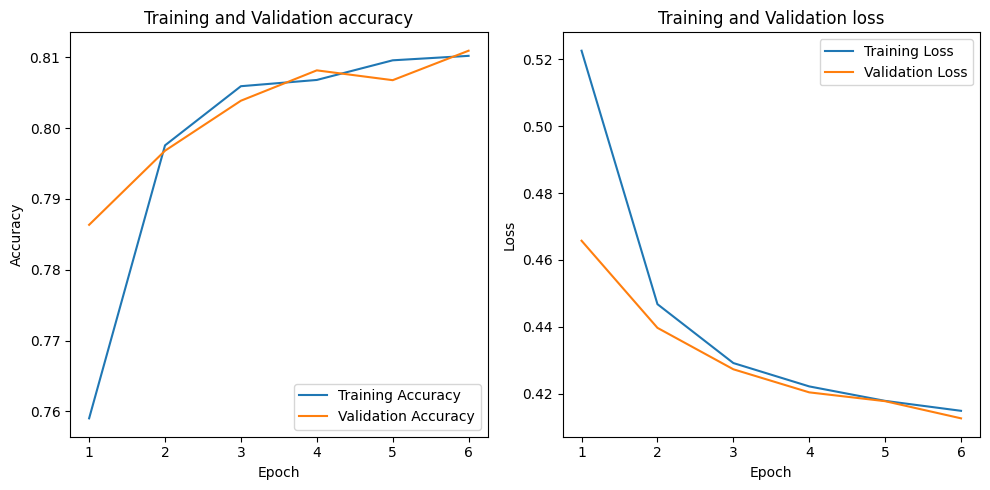

In [21]:
plotLearningCurve(history, epochs)

The graphs show that there is very minimal overfitting since the curves for loss and accuracy are both better in validation than training.

This may indicate that the model is underfitting, but the results are so close that they are negligible.

310/310 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step
Random Forest Classifier Accuracy : 81.09%


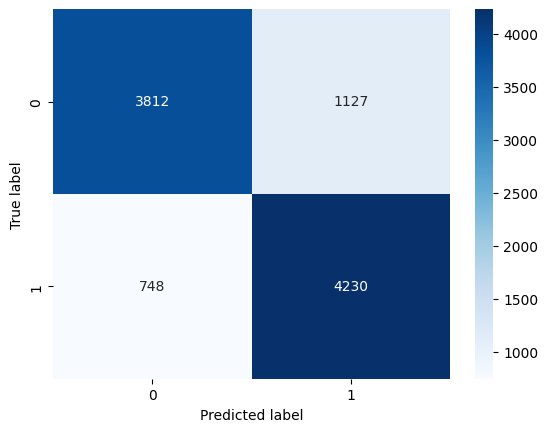

In [22]:
ypred = model.predict(test_dataset)
ypred = ypred>0.5

s2=accuracy_score(ytest_array,ypred)
print("Random Forest Classifier Accuracy :", "{:.2f}%".format(100*s2))

#Get the confusion matrix
cf_matrix = confusion_matrix(ytest_array, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [23]:
ft_bert_report = classification_report(ytest_array, ypred)
print(ft_bert_report)

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      4939
           1       0.79      0.85      0.82      4978

    accuracy                           0.81      9917
   macro avg       0.81      0.81      0.81      9917
weighted avg       0.81      0.81      0.81      9917



### Comparing base DistilBERT vs fine-tuned DistilBERT

The base model performs very poorly and doesn't show any ability to correctly classify the sentiment of reviews, while the fine-tuned model performs very well, correctly classifying reviews 81% of the time.

The fine-tuned model produces more false positives which is likely a side effect of the base model almost always predicting that the reviews were positive. 

# Classical Machine Learning Model: Random Forest


In [24]:
# Re-splitting data since we don't need validation set
train, test= train_test_split(df, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [25]:
# Encoding data for Random Forest
tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

Random Forest Classifier Accuracy : 85.37%


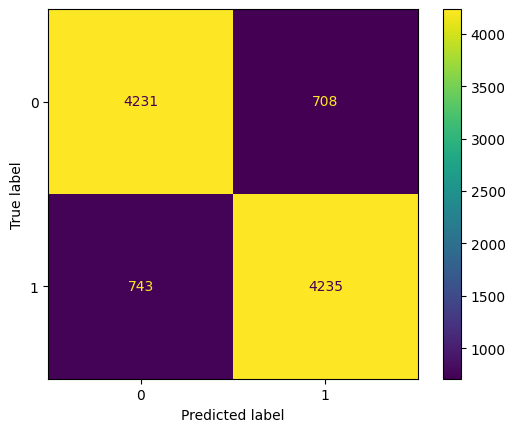

In [26]:
rf = RandomForestClassifier()
rf.fit(Xtrain_tfidf, ytrain)
p2=rf.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Random Forest Classifier Accuracy :", "{:.2f}%".format(100*s2))
ConfusionMatrixDisplay.from_estimator(rf,Xtest_tfidf,ytest)
#plot_confusion_matrix(rf, Xtest_tfidf, ytest,cmap = 'Blues')
plt.grid(False)

In [27]:
rf_report = classification_report(ytest, p2)
print(rf_report)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4939
           1       0.86      0.85      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



# Classification Reports

| Model | Precision (negative) | Recall (negative) | F1-Score (negative) | Precision (positive) | Recall (positive) | F1-Score (positive) |
|---|---|---|---|---|---|---|
| DistilBERT (base) | 0.28 | 0.04 | 0.07 | 0.48 | 0.89 | 0.63 |
| DistilBERT (fine-tuned) | 0.84 | 0.77 | 0.80 | 0.79 | 0.85 | 0.82 |
| Random Forest Classifier | 0.85 | 0.86 | 0.85 | 0.86 | 0.85 | 0.85 |

#### Precision

The base DistilBERT model showed lower precision than choosing at random so it was a complete failure. The fine-tuned DistilBERT model showed comparable precision to the Random Forest Classifier (RF), but was slightly lower with its predictions for positive reviews.

#### Recall

The base DistilBERT model scored very low in it's recall rate for negative reviews, which is expected since it classified almost all of the reviews as positive. It's performace with positive reviews looks good on paper, but since the model almost exlusively predicted that reviews were positive, this metric means almost nothing. A model that predicted every single review to be poitive would recieve a recall of 1.00 despite being incredibly flawed

The fine-tuned DistilBERT model had a slightly lower recall rate with negative reviews than RF, but a similar rate to RF for positive reviews. This finding shows that the RF model would be better at reliably identifying negative reviews than the fine-tuned model.

#### F1-Score

The F1-Scores of the models rank in the following order: base DistilBERT, fine-tuned DistilBERT, RF. Overall, RF was better in almost every metric, but the fine-tuned model was a close second.


# Time Complexity
---
### Random Forest vs. Base DistilBERT

The base distilbert model took roughly the same amount of time to get running as the random forest classifier, but produced very bad results. This means there is no advantage to using the llm without fine-tuning.

### Random Forest vs. Fine-tuned DistilBERT

The random forest classifier (RF) performed better than the fine-tuned distilBERT model despite only taking roughly 2 minutes to train vs the 15+ minutes (4 hrs w/o gpu) of the fine-tuned distilBERT model.

One thing to note is that in the preprocessing stage, we remove all non-descriptive words. Removing these words from the input data inherently gives RF an advantage, because llm's are better at looking at the context of a sentence to determine their output.

It would be interesting to see the performance difference between a larger llm (or distilBERT with more training) and RF without the data preprocessing step that removes "unnecessary" words.